# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 3

## Starting point

In the experimental notebook we trained a network that achieved 99.13% accuracy on the training set.

In this notebook we will attempt to improve it using these techniques:

- More layers
- Batch normalization
- Image augmentation

## Current state of the art

According to [this site](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html), the best MNIST accuracy has 0.21% error rate, i.e 99.79% accuracy.

According to [LeCun's MNIST page](http://yann.lecun.com/exdb/mnist/), the best accuracy has an error rate of 0.23% (99.77% accuracy). To achieve that a "committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions]" was used.

Therefore, that's the maximum can we hope to achieve in these experiments.

# Step 1: Setup

First, make sure that you have installed Keras on your computer.

In [1]:
# Code from https://github.com/keras-team/keras 

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

/var/web_services/galaxy/jupyter_conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1a: Auxiliary functions and constants

Some data manipulation and visualization functions.

Visualize Keras training accuracy and loss, given a `History` object collected from calling `fit()`.

In [3]:
# From https://keras.io/visualization/

def plot_keras_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Train a model, validate on test data and show training loss/accuracy in graphical format.

In [4]:
"""Train a model, validate on test data, show training loss/accuracy in graphical format, save trained model.

Parameters:
   model_generator (function): the function that creates the Keras model to be trained.
   batch_size (int): batch size for training.
   epochs (int): maximum number of epochs to train.
   verbose (int): Keras' verbosity level.
   callbacks (array): Keras' callbacks to use during training.

Returns:
   The trained model and a .h5 file on the local directory with the trained model.
   
Note: assumes that train and test data are set in global variables (see code).
"""
def train_validate_analyze(model_generator, batch_size, epochs, verbose=1, callbacks=None):
    model = model_generator()
    model.summary()
    
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=verbose,
          callbacks=callbacks,
          validation_data=(x_test, y_test))
    
    model.save('trained_model_{}.h5'.format(model_generator.__name__.replace('get_','')))

    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('Test loss:', score[0]) 
    print('Test accuracy:', score[1])
    
    plot_keras_history(history)    
    
    return model

Number of classes in the MNIST dataset.

In [5]:
NUM_CLASSES = 10

# Step 2: Load, split and prepare the MNIST dataset

In [6]:
# Code from https://github.com/keras-team/keras 

# Re-load and re-shape the dataset

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Step 4: Baseline

This is the same network from the experimental notebook, repeated here to have a baseline.

In [7]:
def get_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

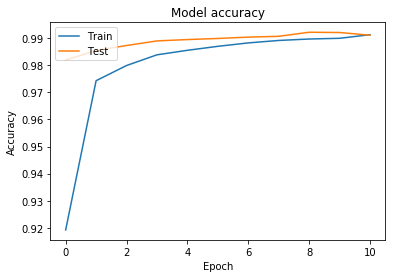

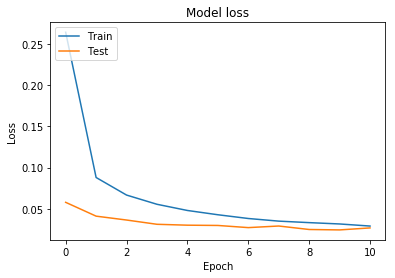

In [8]:
model_baseline = train_validate_analyze(get_baseline_model, batch_size=128, epochs=11)

# Step 5: Add more pooling and dense layers

## Step 5a: LeNet-5-like network

This network adds a second pooling and a second dense layer. It was chosen for a historical reason: it is very close to [LeNet-5 architecture](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

"Very close" because this network uses an adaptive optimizer, while LeNet used SGD (I think, not 100% sure - could not find a good reference, but since it is from the later 1990s, it is likely to be using SGD). It also likely did not use ReLU as activation units.

Another difference is the image size. LeNet used 32x32 images, while we use 28x28 images.

LeNet-5 [achieved 99.05% accuracy](http://yann.lecun.com/exdb/mnist/) without manipulating images.

TODO: compare with https://engmrk.com/lenet-5-a-classic-cnn-architecture/

In [9]:
# based on https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9

from keras.layers import AveragePooling2D

def get_lenet_like_model():
    model = Sequential()
    # First layer in LeNet-5 is 5x5, but it uses 32x32 images
    # Since we are using 28x28 images, we will reduce the kernel to 3x3 to compensate somewhat
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2))) # LeNet uses average pooling, not max pooling
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation = 'softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)                10164     
__________

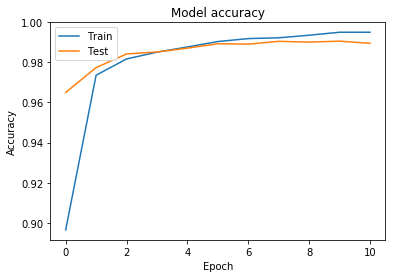

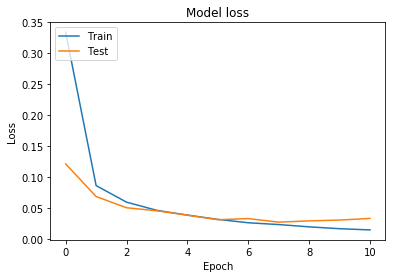

In [10]:
model_lenet_like = train_validate_analyze(get_lenet_like_model, batch_size=128, epochs=11)

This is a decent result for a relatively small network (small number of parameters). It is very close to the result reported in LeCun's paper.

The graphs shows that it is overfitting at around epoch 7. Before we completely give up on it, we will try to deal with the overfitting.

### Deal with overfitting

To try to get more accuracy out of this network we will add dropout layers to fight overfitting.

In [11]:
# based on https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9

from keras.layers import AveragePooling2D

def get_lenet_like_model_with_dropout():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(AveragePooling2D())
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=NUM_CLASSES, activation = 'softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_3 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
__________

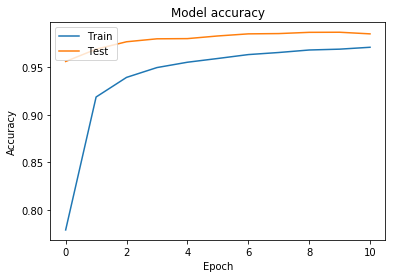

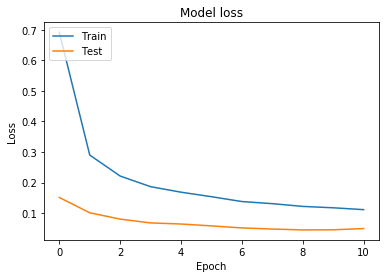

In [12]:
model_lenet_like_with_dropout = train_validate_analyze(get_lenet_like_model_with_dropout, batch_size=128, epochs=11)

It is no longer overfitting. It is now underfitting.

Since it is not overfitting we will push it further with more epochs, before we give up on it.

### Train longer, with early stopping

Now that we are not overfitting we can train for more epochs.

However, we don't know how many epochs ahead of time. We will use Keras' [`EarlyStopping` callback](https://keras.io/callbacks/#earlystopping) to decide when to stop.

With early stopping in place we can use a high number of epochs and rely on the `EarlyStopping` callback to decide when to stop.

In [13]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=2)]
# Keras 2.2.3 has a new parameter: restore_best_weights. It would improve results a bit.
# FAU HPC is running Keras 2.1.x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_5 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
__________

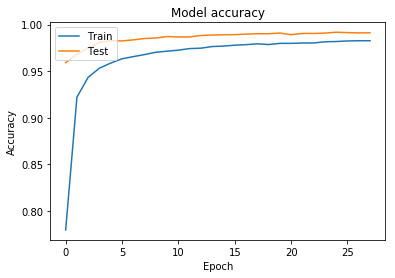

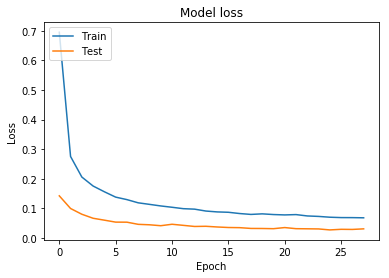

In [14]:
model_lenet_like_early_stopping = train_validate_analyze(get_lenet_like_model_with_dropout, batch_size=128, epochs=100, verbose=2,callbacks=callbacks) 

TODO: add analysis here

## Step 5b: VGG-like network

In this section we will attempt a network topology similar to the VGG network: a series of convolution layers with the same filter size, with pooling layers in between, followed by large dense layers.

The distinguishing feature of this network is the repetition of the same 3 x 3 filter in all convolution layers.

In [15]:
# based on https://medium.com/@amir_hf8/implementing-vgg13-for-mnist-dataset-in-tensorflow-abc1460e2b93

def get_vgg_like_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape, padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=1000, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation = 'softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    return model

Train with early stopping.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 256)         295168    
__________

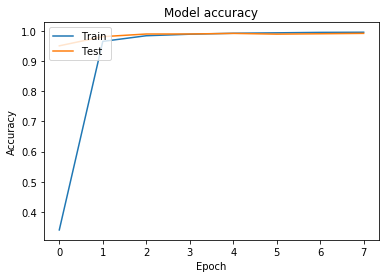

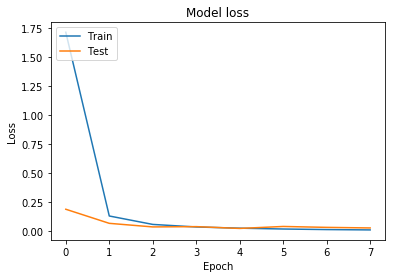

In [16]:
model_vgg_like = train_validate_analyze(get_vgg_like_model, batch_size=128, epochs=100, verbose=2,callbacks=callbacks) 

TODO: Analysis

# Step 6: Select the best model

# Step 7: Analyze the best model

## Step 7a: Visualize the model

In [17]:
# Requires pydot and graphviz - will **NOT** work in FAU's HPC as of March/2019
#  pip install pydot
#  pit install graphviz

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Sizing code from https://stackoverflow.com/a/54965459
dot_model = model_to_dot(model_lenet_like_with_dropout, show_layer_names=False, show_shapes=True)
dot_model.set_size('6x4') # size in inches
SVG(dot_model.create(prog='dot', format='svg'))

"dot" with args ['-Tps', '/tmp/tmpw7t3dw5o'] returned code: 1

stdout, stderr:
 b''
b'Error: /usr/lib64/graphviz/config6 is zero sized, or other read error.\nError: /usr/lib64/graphviz/config6 is zero sized, or other read error.\nFormat: "ps" not recognized. Use one of:\n'



ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.